# Описание проекта

Подготовка прототипа модели машинного обучения для индустриальной кампании. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Исходные данные содержат параметры добычи и очистки руды. Модель должна помогать оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### План работ <a class="tocSkip">

1. Подготовка данных   
1.1. Импорт данных и их общий анализ  
1.2. Проверка расчета эффективности обогащения  
1.3. Анализ признаков, недоступных в тестовой выборке  
1.4. Предобработка данных   
1.5. Выводы  
2. Анализ данных  
2.1. Изучение изменений концентраций металлов (Au, Ag, Pb) на различных этапах очистки  
2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках  
2.3. Исследование суммарной концентрацию всех веществ на разных стадиях очистки  
2.4. Выводы  
3. Построение модели  
3.1. Написание функции для вычисления итоговой метрики (sMAPE)   
3.2. Обучение моделей, анализ их качества, выбор лучшей  
3.3. Проверка выбранной модели на тестовой выборке  
3.4. Выводы  

### Описание технологии очитски золотоносной руды <a class="tocSkip">

Очистка золотоносной руды состоит из нескольких этапов, выполняемых последовательно один за другим.
1. Флотация. На этом этапе происходит обогащение золотоносной руды. На вход подается золотоносная руда на выходе получается черновой концентрат и "отвальные хвосты" (остатки продукта с низкой концентрацией золота).
2. Очистка. Она состоит из двух этапов - первого и второго. На вход подается черновой концентрат, на выходе получаетя финальный концентрат. На каждом этапе очистки также образуются отвальные хвосты. 

### Описание данных <a class="tocSkip">

***Технологический процесс***  
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
&nbsp;&nbsp;&nbsp;Xanthate — ксантогенат (промотер, или активатор флотации);  
&nbsp;&nbsp;&nbsp;Sulphate — сульфат (на данном производстве сульфид натрия);  
&nbsp;&nbsp;&nbsp;Depressant — депрессант (силикат натрия)  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  

***Параметры этапов***  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  

***Наименование признаков***  
*Наименование признаков должно быть такое:*  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag   

*Возможные значения для блока [этап]:*  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики 

*Возможные значения для блока [тип_параметра]:*  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

### Расчет эффективности обогащения <a class="tocSkip">

Расчет эффективности обогащения *Recovery* производится по формуле:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Recovery* = 100% * {*C* * (*F* - *T*)} / {*F* * (*C* - *T*)},  
*C* — доля золота в концентрате после флотации/очистки;  
*F* — доля золота в сырье/концентрате до флотации/очистки;   
*T* — доля золота в отвальных хвостах после флотации/очистки.  
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

### Метрика качества <a class="tocSkip">

Оценки качества модели будет производиться метрикой — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Итоговая метрика рассчитывается как:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*sMAPE(итоговая)* = 25% * sMAPE(флотация) + 75% * sMAPE(очистка)  

## Подготовка данных

### Импорт данных и их общий анализ

In [1]:
#импорт библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.ticker
import random

In [2]:
#импорт функций для задачи  регрессии
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.stats import variation
import warnings

In [3]:
#импорт данных
train_set = pd.read_csv('/datasets/gold_recovery_train.csv')   #тренировочная выборка
test_set = pd.read_csv('/datasets/gold_recovery_test.csv')     #тестовая выборка
full_set = pd.read_csv('/datasets/gold_recovery_full.csv')     #исходные данные

In [4]:
#вывод общей информации о датасетах
train_set.info()
#test_set.info
#full_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
#вывод датасетов
#train_set
#test_set
#full_set

Первичный анализ данных показывает, что в данных содержатся пропуски, даты не приведены к типу datatime. Необходима подготовка данных для дальнейшего анализа.

### Проверка расчета эффективности обогащения

Напишем функцию для расчета эффективности обогощения

In [6]:
#Фнуция расчета эффективности обогощениря руды
#входные параметры
#input_fraction — доля золота в сырье/концентрате до проведения заданного этапа очистки
#output_fraction — доля золота в концентрате после проведения заданного этапа очистки
#tails_fraction — доля золота в отвальных хвостах после проведения этапа очистки
def Recovery(input_fraction, output_fraction, tails_fraction):
    
    #сведение данных в таблицу и удаление пропусков в ней
    
    #вычисления по формуле, см. раздел Описание проекта/Расчет эффективности обогащения
    recovery = (100 * output_fraction * (input_fraction - tails_fraction)) / \
                     ( input_fraction * (output_fraction - tails_fraction))
    
    return recovery

Проверим, что эффективность обогащения рассчитана правильно. Для этого вычислим её на обучающей выборке для признака rougher.output.recovery, т.е. эффективность обогащения после флотации. 
Эта величина рассчитывается исходя из:   
&nbsp;&nbsp;&nbsp;&nbsp; доли золота в концентрате после флотации - rougher.output.concentrate_au   
&nbsp;&nbsp;&nbsp;&nbsp; доли доля золота в сырье до флотации - rougher.input.feed_au     
&nbsp;&nbsp;&nbsp;&nbsp; доли золота в отвальных хвостах после флотации - rougher.output.tail_au  

In [7]:
#задание входных параметров для функции Recovery
input_fraction = train_set['rougher.input.feed_au']
output_fraction = train_set['rougher.output.concentrate_au']
tails_fraction = train_set['rougher.output.tail_au']
recovery_check = train_set['rougher.output.recovery']
recovery_check

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

In [8]:
#поскольку колонки содержат пропуски, скопируем необходимые данные в отдельный датафрейм
recovery_check = pd.concat([input_fraction, output_fraction, tails_fraction, recovery_check], \
                           axis=1, join='inner').copy()

recovery_check.columns = ['input_', 'output_', 'tails', 'recovery']

#удаление пропусков
recovery_check = recovery_check.dropna()

#recovery_check

In [9]:
#расчет эффективности обогащения и оценка ошибки по MAE
recovery = Recovery(recovery_check['input_'], recovery_check['output_'], recovery_check['tails'])
mae = mean_absolute_error(recovery_check['recovery'], recovery)
print('Оценка ошибки расчета эффективности обогащения, MAE =', mae)

Оценка ошибки расчета эффективности обогащения, MAE = 1.1290254018238898e-14


Ощибка крайне мала, практически равна нулю! Это значит, что ошибок в данных нет и эффективность обогащения рассчитана правильно.

### Анализ признаков, недоступных в тестовой выборке

In [10]:
#список колонок с именами признаков, которых нет в тестовой выборке
difference = full_set.columns.difference(test_set.columns)
print('Число отсутстсвующих признаков в тестовой выборке', len(difference))
print('Отсутствующие признаки')
print(difference)

Число отсутстсвующих признаков в тестовой выборке 34
Отсутствующие признаки
Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'roug

Из списка признаков видно, что в тестовой выборке отсутствуют целевые признаки - доли реагентов в концентратах и хвостах, а также признаки в которых содержатся расчетные данные, получаемые вычислением из других признаков. Расчетные данные имеют тип параметра 'calculation'.

### Предобработка данных

***Преобразование типа колонки 'date' к типу datetime***

In [11]:
#приведение к дате времени
train_set['date'] = pd.to_datetime(train_set['date'], format='%Y-%m-%dT%H:%M:%S')
test_set['date'] = pd.to_datetime(test_set['date'], format='%Y-%m-%dT%H:%M:%S')
full_set['date'] = pd.to_datetime(full_set['date'], format='%Y-%m-%dT%H:%M:%S')
full_set['date']

0       2016-01-15 00:00:00
1       2016-01-15 01:00:00
2       2016-01-15 02:00:00
3       2016-01-15 03:00:00
4       2016-01-15 04:00:00
                ...        
22711   2018-08-18 06:59:59
22712   2018-08-18 07:59:59
22713   2018-08-18 08:59:59
22714   2018-08-18 09:59:59
22715   2018-08-18 10:59:59
Name: date, Length: 22716, dtype: datetime64[ns]

In [12]:
full_set_copy = full_set.dropna().copy()
#print(len(full_set_copy))
#print(len(full_set))

***Дополнение тестовой выборки данными из исходного набора***

Дополнение будем производить по дате и времени записи данных.

In [13]:
#выделение колонок содержащих индексы полного датасета
train_set['full_index'] = 0
test_set['full_index'] = 0

#выделние индексов из полного датасета для признаков из обучающей и тестовой выборок
test_index_list = full_set.loc[full_set['date'].isin(test_set['date'])].index.tolist()
train_index_list = full_set.loc[full_set['date'].isin(train_set['date'])].index.tolist()

train_set['full_index'] = train_index_list
test_set['full_index'] = test_index_list

In [14]:
#проверка правильности выделения индексов для обучающей выборки
tr1 = train_set['date']
tr2 = full_set['date'][full_set['date'].index.isin(train_set['full_index'])].reset_index(drop = True) 

#сравнение данных по дате для обучающей выборки
compare1 = tr1.equals(tr2)
print(compare1)

#проверка правильности выделения индексов для тестовой выборки
tst1 = test_set['date']
tst2 = full_set['date'][full_set['date'].index.isin(test_set['full_index'])].reset_index(drop = True)

#сравнение данных по дате для тестовой выборки
compare2 = tr1.equals(tr2)
print(compare2)

True
True


In [15]:
#замена индкусов в датасетах, содержащих обучающую и тестовую выборки
train_set = train_set.set_index(pd.Series(train_index_list))
test_set = test_set.set_index(pd.Series(test_index_list))
#test_set

In [16]:
#добавление к тестовой выборке данных из датафрейма с полным набором данных
full_set_test = full_set[difference][full_set[difference].index.isin(test_set['full_index'])]
#print(full_set_test)

#дополнение тестовой выборки необходимыми данными
test_set = pd.concat([test_set, full_set_test], axis = 1)
difference_concat = full_set.columns.difference(test_set.columns)
print('Число отсутстсвующих признаков в тестовой выборке', len(difference_concat))

Число отсутстсвующих признаков в тестовой выборке 0


***Удаление полных дубликатов***

In [17]:
print('Количество полных дубликатов в тренировочной выборке равно', train_set.duplicated().sum())
print('Количество полных дубликатов в обучающей выборке равно', test_set.duplicated().sum())
train_set = train_set.drop_duplicates().reset_index(drop = True)
test_set = test_set.drop_duplicates().reset_index(drop = True)

Количество полных дубликатов в тренировочной выборке равно 0
Количество полных дубликатов в обучающей выборке равно 0


***Вспомогательные функции и списки названий параметров***

В дальнейшем нам понадобятся функции для более удобной работы с названиеями колонок. Создадим функции для анализа названий по стадии, параметрц и типу параметра, которые составляют название колонок.

In [18]:
#функция декомпозиции имени колонки 
def FeaturesDecomposition(columns_names, splitter):
    
    column_name_split_list = []
    for column in columns_names:
        column_name = column.split(splitter)
        column_name_split_list.append(column_name)
        
    column_name_split_list = pd.Series(column_name_split_list)
    
    return column_name_split_list

In [19]:
#композиция колонок для заданного этапа
def FeatureComposition(columns_names, splitter, stage_name_list, drop_list):
    
    #список колонок содержащих в названии указанный технологический этап
    stage_columns = []
    final_stage_list = []
    columns_drop_list = []
    
    columns_stage_list = FeaturesDecomposition(columns_names, splitter)
        
    #декомпозиция названия колоноки - выбор этапа и композиция имен, содержащих навзание этапа
    for i in range(len(columns_stage_list)):
        for j in range(len(stage_name_list)):
            if stage_name_list[j] in columns_stage_list[i]:
                stage_columns.append(columns_stage_list[i])
    
    #исключение не нужных колонок
    for i in range(len(stage_columns)):
        exist = False
        for j in range(len(drop_list)):
            if drop_list[j] in stage_columns[i]:
                exist = True
                column = '.'.join(stage_columns[i])
                columns_drop_list.append(column)  #запись списка с исключенными колонками 
                
        if exist == False:
            column = '.'.join(stage_columns[i])
            final_stage_list.append(column)       #запись списка с включенными колонками 
    
    return final_stage_list, columns_drop_list

In [20]:
#анализ названий параметров в наименованиях колонок
def ParameterType(columns_names, product_type, select_metall, drop, splitter_levels, stage):
    
    #список колонок содержащих в названии указанное название параметра
    columns_selected = []
    columns_dropped = []
    
    columns_lists = FeaturesDecomposition(columns_names, splitter_levels['primal'])
    
    
    #анализ названия параметра
    for i in range(len(columns_lists)):
        
        split_type = FeaturesDecomposition(columns_lists[i], splitter_levels['secondary'])
        
        for j in range(len(product_type)):
            #print(split_type[0])
            
            #выявление требуемых типов продукта
            if stage == 'whole':
                if (product_type[j] in split_type[2]) & (select_metall in split_type[2]) &\
                   (drop != split_type[1]):
                    column = '.'.join(columns_lists[i])
                    columns_selected.append(column)
            if (stage != 'whole') & (stage in split_type[0]):
                if (product_type[j] in split_type[2]) & (select_metall in split_type[2]) &\
                    (drop != split_type[1]):
                    column = '.'.join(columns_lists[i])
                    columns_selected.append(column)
         
    return columns_selected    

In [21]:
#композиция имени колоноки по её признакам (стадия, параметрв и тип параметра)
def OneColumnSelection(stage, state, parameter_1, parameter_2):
    
    column_name = stage + '.' + state + '.' + parameter_1 + '_' + parameter_2
             
    return column_name

In [22]:
#выбор названий по признакам в имени колонки (стадия, параметрв и тип параметра)
def ColumnsSelection(stages_names, states_names, parameters_1, parameters_2):
    
    columns_names_list = []
    
    #последовательный проход по всем признакам названия колонки
    for stage_name in stages_names:
        for state_name in states_names:
            for parameter_1_name in parameters_1:
                for parameter_2_name in parameters_2:
                    column_name = OneColumnSelection(stage_name, state_name, \
                                                     parameter_1_name, parameter_2_name)
                    columns_names_list.append(column_name)
                
    return columns_names_list              

Создадим списки параметров для дальнейшего разбиения данных

In [23]:
#список названий этапов
stage_rougher = ['rougher']
stage_whole = ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']
stage_tags = ['rougher', 'primary', 'secondary', 'final']

#список типов выходных параметров продукта необходимы для расчета эффективности обогащения и метрик
output_type = ['output']

#список типов входных параметров сырья необходимы для расчета эффективности обогащения
input_type = ['input']

#список параметров состояния и расчетов 
current_state_names = ['state', 'calculation']

#списки типов промежуточных целевых признаков металлов 
drop_metalls = ['concentrate_ag', 'concentrate_pb', 'concentrate_sol', 'concentrate_au']
drop_tails = ['tail_ag', 'tail_pb', 'tail_sol', 'tail_au']
drop_calculation = ['calculation']
drop_feed = ['feed_ag', 'feed_pb', 'feed_sol', 'feed_au']
drop_sol = ['feed_sol', 'concentrate_sol', 'tail_sol']

#список типов продукта
product_type = ['feed', 'concentrate', 'tail']
product_tail = ['tail']
product_metall = ['feed', 'concentrate']
metalls = ['ag', 'pb', 'au']
reagents = ['ag', 'pb', 'au', 'sol']

#эффективность 
recovery_name = ['recovery']

#список структурных параметров руды
feed_list = ['feed_size', 'feed_rate']

In [24]:
#входные и выходные параметры необходимые для расчета эффективности обогащения
rougher_input = ['feed']
rougher_output = ['concentrate', 'tail']
cleaner_input = ['concentrate']
cleaner_output = ['tail','concentrate']

In [25]:
splitters = {
    'primal' : '.',
    'secondary': '_'
}

***Анализ пропусков***

Удалим пропуски в данных, поскольку неправильная замена пропусков может привести к существенному искажению данных. Количество признаков велико и они имеют сложную взаимосвязь, поэтому неправильно заполнение пропусков в одной колонке может привести к искажению между признаками и целевыми признаками. Заполним пропуски перед выделением признаков и целевых признаков. 

In [26]:
#удаление пропусков
train_set = train_set.dropna()
test_set = test_set.dropna()

In [27]:
#удаление не нужных колонок из списка всех колонок
#создание списка колонок
total_features_train = pd.Series(train_set.columns)
total_features_test = pd.Series(test_set.columns)

#определение номеров колонок содержащих recovery
exclude_list_train = FeaturesDecomposition(total_features_train, '.')
exclude_list_test = FeaturesDecomposition(total_features_test, '.')
#len(exclude_list_test) - len(exclude_list_train)

In [28]:
recovery_columns_train = []
recovery_columns_test = []

#поиск колонок содержащих recovery
for i in range(len(exclude_list_train)):
    if 'recovery' in exclude_list_train[i]:  #исключение из списка для обучающей выборки
        recovery_columns_train.append(i)
        
    if 'recovery' in exclude_list_test[i]:    #исключение из списка для тестовой выборки
        recovery_columns_test.append(i)
        

print('Обучающая выборка', recovery_columns_train)
print('Тестовая выборка', recovery_columns_test)

Обучающая выборка [5, 48]
Тестовая выборка [58, 79]


Поскольку из данных о финальных значениях золота (на каждом этапе) рассчитывается эффективность обогащения,которая является целевым признаком, то исключим данные о долях металлов в концентрате и хвостах из тренировочной выборки. Удаление пропусков будем проводить уже после выделения признаков и целевых признаков.

In [29]:
#функция выделения из данных датафреймов для этапов флотации и всего процесса
def FeaturesSelection(data, target, stage, drop_list, splitter):
    
    #if stage[0] == 'rougher':
    drop_list_add = ['none']

    #список колонок для всего этапа 
    selected_columns, drop = FeatureComposition(data.columns, splitter, stage, drop_list_add)
    
    #список колонок с признаками без промежуточных целевых признаков
    features_columns, drop = FeatureComposition(selected_columns, splitter, stage, drop_list)
    
    #создание датафреймов с данными для анализа флотации или всего процесса очистки
    features_data_full = pd.DataFrame(np.zeros((len(data), len(features_columns))), \
                                index = data.index, columns = features_columns)
    
    #выделение и целевых и обычных признаков
    features_data_full = data[features_columns].copy()
    
    #удаление пропусков
    features_data_full = features_data_full.dropna()
    features_data_full = features_data_full[~features_data_full.isin([np.nan, np.inf, -np.inf]).any(1)]
    features_data_full = features_data_full.reset_index(drop = True)
    
    #выделение признаков
    features_data = features_data_full.drop(target, axis = 1)
    target_data = features_data_full[target]
    
    return features_data, target_data, 
    #return selected_columns, features_columns

### Выводы

* Проверена правильность расчета Recovery
* Тестовая выборка дополнена данными из исходной выборки
* Проведена предподготовка данных, выделены признаки и целевые признаки для тренировочной и тестовой выборок. 

## Анализ данных

### Изучение изменений концентраций металлов (Au, Ag, Pb) на различных этапах очистки

Выделим концентрации металлов в руде, концентратах и хвостах и проанализируем их.

In [30]:
#анализ концентраций метллов по полной выборке
columns_full = full_set.drop(['date'], axis = 1).columns
metall_name = {
    'ag' : 'серебро',
    'au' : 'золото',
    'pb' : 'свинец',
    'sol' : 'реагенты'
}

In [31]:
#выделение концентраций металлов на различных стадиях
def SelectMetall(columns_list, metall, stage):
    
    mean_c = []
    
    drop = ['calculation']
    #выделение долей металлав руде и концентрате
    selected_c = ParameterType(columns_list, product_metall, metall, drop, splitters, stage)
    #выделение долей металлав в хвостах
    selected_t = ParameterType(columns_list, product_tail, metall, drop, splitters, stage)
    
    metall_c = full_set[selected_c].dropna()
    metall_t = full_set[selected_t].dropna()
    
    metall_c.columns = ['final', 'primary', 'initial', 'rougher']
    metall_c = metall_c[['initial', 'rougher', 'primary', 'final']]
    
    metall_t.columns = ['final', 'primary', 'rougher', 'secondary']
    metall_t = metall_t[['rougher', 'primary', 'secondary', 'final']] 
    
    for column in metall_c:
        mean_c_stage = metall_c[column].mean()
        mean_c.append(mean_c_stage)
    
    return metall_c, metall_t, mean_c

In [32]:
#построение графиков распределений конентраций металла
def MetallDistribution(m_c, m_t, metall):
    
    xlim_c = []
    xlim_t = []
    ylim_c = []
    ylim_t = []
    
    title = 'Распределений концентраций:' + ' ' + metall_name[metall]

    legend_c = ['начальная', 'после флотации', 'после первой очистки', 'финальная']
    legend_t = ['после флотации', 'после первой очистки', 'после второй очистки', 'финальная']
    
    for name in m_c:
        xlim_c.append(m_c[name].max())
    for name in m_t:
        xlim_t.append(m_t[name].max())
    
    xlim_c_right = pd.Series(xlim_c).max()  
    xlim_t_right = pd.Series(xlim_t).max() 
                      
    ylim_c_right = pd.Series(ylim_c).max()  
    ylim_t_right = pd.Series(ylim_t).max() 
                      
    
    fig, axes = plt.subplots(1,2, figsize = (12,6)) 
    plt.suptitle(title);

    #построение гистограмм
    for j in range(len(m_c.columns)):
        axes[0]= m_c.iloc[:, j].hist(bins = 100, ax = axes[0]);
        axes[1] = m_t.iloc[:, j].hist(bins = 100, ax = axes[1]);
        
    #print(axes[0])

    axes[0].set_xlabel('концентрация');
    axes[0].set_ylabel('частота');
    axes[0].legend(legend_c);
    axes[0].set_xlim(1,xlim_c_right)
    axes[0].set_ylim(0,2500)
    
    axes[1].set_xlabel('концентрация');
    axes[1].set_ylabel('частота');
    axes[1].legend(legend_t);
    axes[1].set_xlim(1,xlim_t_right)
    axes[1].set_ylim(0,1600)
    

In [33]:
#создание датафрейма для записи средних значений концентраций
df_mean_stage = pd.DataFrame() 

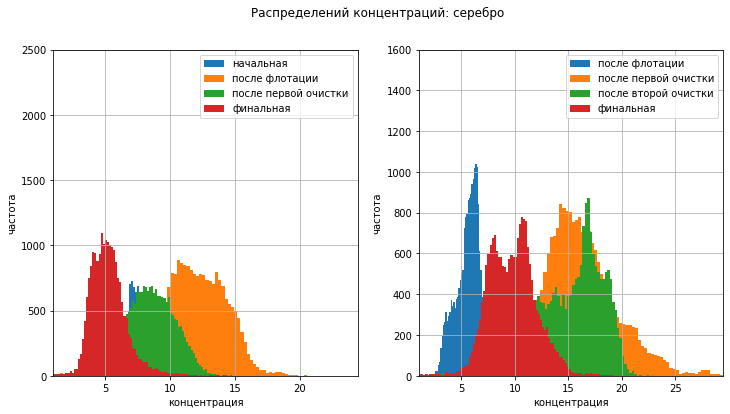

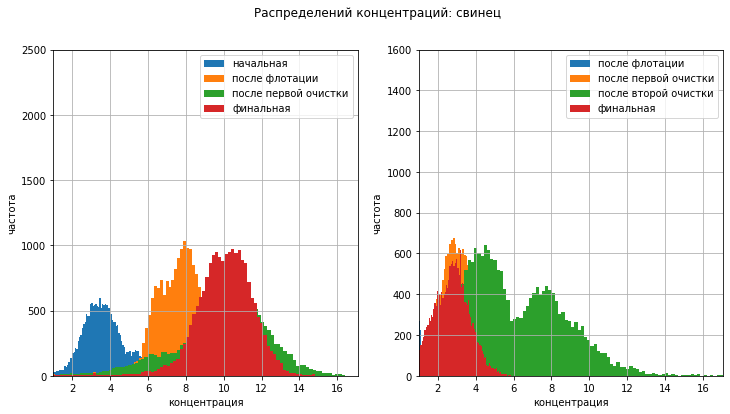

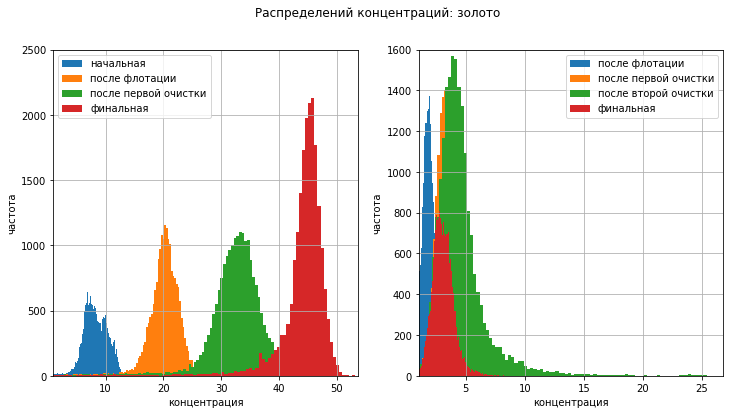

In [34]:
data_mean_c = []
data_metall_c = []

#построение гистограмм распредлелений металлов
for metall in metalls:
    m_c, m_t, mean_c = SelectMetall(columns_full, metall, 'whole')

    df_mean_stage[metall] = pd.Series(mean_c)
    MetallDistribution(m_c, m_t, metall)   

Из гистогармм видно, что концентрация золота растет после каждого этапа очистки. При этом концентраци золота в хвостах мала на протяжении всех этапов. Концентрации свинца слабо растет по ходу процесса обогащения. Концентрация же серебра падает, при этом концетрация серебра в хвостах выше чем концентрация серебра в концентрате. 

In [35]:
mean_stage = df_mean_stage.T
mean_stage.columns = ['initial', 'rougher', 'primary', 'final']
mean_stage

,initial,rougher,primary,final
ag,8.069611,10.879444,7.695721,4.785180
pb,3.321244,6.932543,8.963695,9.178636
au,7.569196,17.888219,29.226573,40.028011


Из таблицы видно, что в ходе процесса обогащения, концентрация золота увеличивается болле, чем в 5 раз, концентрация свинца увеличивается примерно в три раза, а концентрация серебра падает примерно в полтора раза. 

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках 

Перед анализом распределений размеров гранул исключим из рассмотрения случаи когда их размер равен нулю. Такое возможно, либо при заполнении пропусков, либо из-за ошибок внесения записей в исходные данные.

In [36]:
#тренировочная выборка
train_set = train_set.loc[train_set.loc[:,'rougher.input.feed_size'] > 0]
train_set = train_set.loc[train_set.loc[:,'primary_cleaner.input.feed_size'] > 0]

#тестовая выборка
test_set = test_set.loc[test_set.loc[:,'rougher.input.feed_size'] > 0]
test_set = test_set.loc[test_set.loc[:,'primary_cleaner.input.feed_size'] > 0]

In [37]:
#выделение размеров частиц для тренировочной и тестовой выборок
feed_size_train = train_set[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]
feed_size_test = test_set[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]
#feed_size_train.shape

In [38]:
#переименование колонок
feed_size_train.columns = ['rougher', 'primary_cleaner']
feed_size_test.columns = ['rougher', 'primary_cleaner']

Построим распределения размеров и сравним средние значения

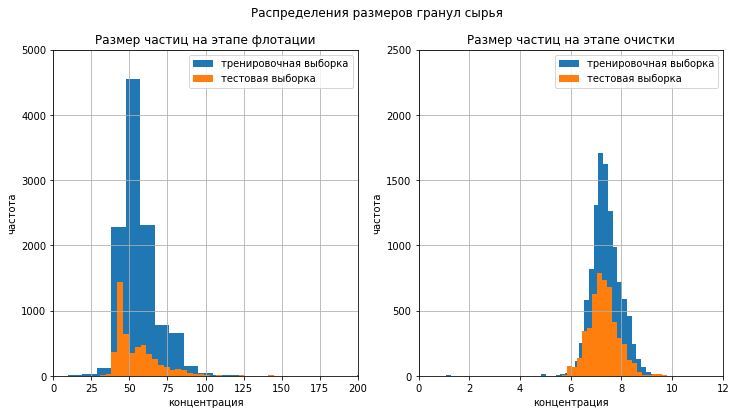

In [39]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
plt.suptitle('Распределения размеров гранул сырья');

#построения гистограмм
#флотация
axes[0] = feed_size_train['rougher'].hist(bins = 50, ax = axes[0]);
axes[0] = feed_size_test['rougher'].hist(bins = 50, ax = axes[0]);

#первичная оценка
axes[1] = feed_size_train['primary_cleaner'].hist(bins = 50, ax = axes[1]);
axes[1] = feed_size_test['primary_cleaner'].hist(bins = 50, ax = axes[1]);

axes[0].set_xlabel('концентрация');
axes[0].set_ylabel('частота');
axes[0].legend(['тренировочная выборка', 'тестовая выборка']);
axes[0].set_xlim(0,200);
axes[0].set_ylim(0,5000);
axes[0].set_title('Размер частиц на этапе флотации')
    
axes[1].set_xlabel('концентрация');
axes[1].set_ylabel('частота');
axes[1].legend(['тренировочная выборка', 'тестовая выборка']);
axes[1].set_xlim(0,12);
axes[1].set_ylim(0,2500);
axes[1].set_title('Размер частиц на этапе очистки');

Из сравнения гистограмм видно, что размеры гранул сырья распределены практически одинаково. 

In [40]:
stage_size_name = ['флотации', 'очистки']
stage_size = ['rougher','primary_cleaner']

for i in range(len(feed_size_train.columns)):
    print('Средний размер гранул сырья на этапе', stage_size_name[i])
    print('Тренировочная выборка {:.2f}'.format(feed_size_train[stage_size[i]].mean()))
    print('Тестовая выборка {:.2f}'.format(feed_size_test[stage_size[i]].mean()))
    print()

Средний размер гранул сырья на этапе флотации
Тренировочная выборка 57.22
Тестовая выборка 55.02

Средний размер гранул сырья на этапе очистки
Тренировочная выборка 7.40
Тестовая выборка 7.29



*Полученные результаты показывают, что средние значения близки друг другу*

In [41]:
stage_size_name = ['флотации', 'очистки']
stage_size = ['rougher','primary_cleaner']

for i in range(len(feed_size_train.columns)):
    print('90% доверительный интервал гранул сырья на этапе', stage_size_name[i])
    print('Тренировочная выборка {:.2f} - {:.2f}'.format(feed_size_train[stage_size[i]].quantile(0.05),\
                                                feed_size_train[stage_size[i]].quantile(0.95)))
    print('Тестовая выборка {:.2f} - {:.2f}'.format(feed_size_test[stage_size[i]].quantile(0.05),\
                                           feed_size_test[stage_size[i]].quantile(0.95)))
    print()

90% доверительный интервал гранул сырья на этапе флотации
Тренировочная выборка 42.24 - 81.10
Тестовая выборка 41.26 - 84.00

90% доверительный интервал гранул сырья на этапе очистки
Тренировочная выборка 6.55 - 8.40
Тестовая выборка 6.42 - 8.28



Полученные значения среднего и доверительных интервалов указывают на то, что размеры гранул сырья для  тренировочной и тестовой выборок лежат в одном диапазоне, а значит не должно быть проблем с обучением и тестированием модели на разнородных данных.

### Исследование суммарной концентрацию всех веществ на разных стадиях очистки

In [42]:
#задание параметров для селекции колонок
rougher_input = {
    'stages' : ['rougher'],
    'states' : ['input'],
    'parameters_1' : ['feed'],
    'parameters_2' : ['ag', 'pb', 'sol', 'au']
}

rougher_output = {
    'stages' : ['rougher'],
    'states' : ['output'],
    'parameters_1' : ['concentrate', 'tail'],
    'parameters_2' : ['ag', 'pb', 'sol', 'au']
}

primary_input = {
    'stages' : ['rougher'],
    'states' : ['output'],
    'parameters_1' : ['concentrate'],
    'parameters_2' : ['ag', 'pb', 'sol', 'au']
}


primary_output = {
    'stages' : ['primary_cleaner'],
    'states' : ['output'],
    'parameters_1' : ['concentrate'],
    'parameters_2' : ['ag', 'pb', 'sol', 'au']
}

final_concentrate = {
    'stages' : ['final'],
    'states' : ['output'],
    'parameters_1' : ['concentrate'],
    'parameters_2' : ['ag', 'pb', 'sol', 'au']
}

In [43]:
#функция для расчета суммарной концентрации на заданном этапе
def ConcentrateTotal(data, input_):
    
    #расчет суммарной концентраций до начала этапа
    stage_list = ColumnsSelection(input_['stages'], input_['states'], \
                                        input_['parameters_1'], input_['parameters_2'])
    stage_data = data[stage_list]

    stage_data_sum = stage_data.sum(axis = 1)
    
    return stage_data_sum

In [44]:
def StagesTotal(data):
    #расчет и сохраненеие разностей суммарных концентраций
    data_list = []
    data_diff = []

    rougher_sum = ConcentrateTotal(data, rougher_input)
    data_list.append(rougher_sum)

    primary_sum = ConcentrateTotal(data, primary_output)
    data_list.append(primary_sum)

    final_sum = ConcentrateTotal(data, final_concentrate)
    data_list.append(final_sum)
    
    
    
    return data_list

In [45]:
#функция построения гистограмм распределения
def PlotDifference(data_list_1, data_list_2, stage_names):
    
    fig, axes = plt.subplots(1, 2, figsize = (12,5))
    plt.suptitle('Распределения суммарных концентрации реагентов');
    
    for i in range(len(data_list_1)):
        axes[0] = data_list_1[i].hist(bins = 100, ax = axes[0], alpha = 0.75);
        axes[1] = data_list_2[i].hist(bins = 100, ax = axes[1], alpha = 0.75);

    axes[0].set_ylabel('частота');
    axes[0].set_xlabel('концентрация');
    axes[0].legend(stage_names);
    axes[0].set_title('Тренировочная выборка');
    
    axes[1].set_ylabel('частота');
    axes[1].set_xlabel('концентрация');
    axes[1].legend(stage_names);
    axes[1].set_title('Тестовая выборка');

Построим распределения разностей суммарных концентраций на каждой стадии для тренировочной и тестовой выборок.

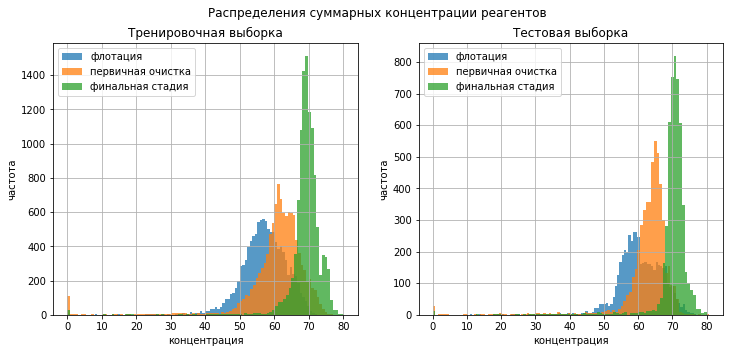

In [46]:
#построение гистограмм
stages_names = ['флотация', 'первичная очистка', 'финальная стадия']

data_list_1 = StagesTotal(train_set)
data_list_2 = StagesTotal(test_set)

PlotDifference(data_list_1, data_list_2, stages_names)

Из представленных данных видно, что в распределении много значений соответствующим нулевым суммарным концентрациям. Это означает, что на входе процесса обогащения либо не было золота, а значит его нельзя и очистить. либо возникли ошибки в записях. Исключим эти значения из рассмотрения. 

In [47]:
#удаление аномальных значений для тренировочной выборки
print(train_set.shape)

train_set_filtered = train_set.loc[(data_list_1[0] > 0) & (data_list_1[1] > 0) &\
                                    (data_list_1[2] > 0)].copy()
print(train_set_filtered.shape)

(11017, 88)
(10939, 88)


In [48]:
#удаление аномальных значений для тренировочной выборки
print(test_set.shape)

test_set_filtered = test_set.loc[(data_list_2[0] > 0) & (data_list_2[1] > 0) &\
                                    (data_list_2[2] > 0)].copy()
print(test_set_filtered.shape)

(5077, 88)
(5037, 88)


Выделение признаков и целевых признаков для анализа всего процесса очистки

* Тренировочная выборка

In [49]:
target = ['rougher.output.recovery','final.output.recovery']
drop_list = drop_metalls + drop_tails + ['calculation']

#выделение данных для анализа всего этапа очистки
features_train, target_train = \
            FeaturesSelection(train_set_filtered, target, stage_whole, drop_list, splitters['primal'])

In [50]:
print('Тренировочная выборка, признаки', features_train.shape)
print('Тренировочная выборка, целевые признаки', target_train.shape)

Тренировочная выборка, признаки (10939, 52)
Тренировочная выборка, целевые признаки (10939, 2)


Выделение признаков и целевых признаков для анализа всего процесса очистки

* Тестовая выборка

In [51]:
target = ['rougher.output.recovery','final.output.recovery']
drop_list = drop_metalls + drop_tails + ['calculation']

#выделение данных для анализа всего этапа очистки
features_test, target_test = \
             FeaturesSelection(test_set_filtered, target, stage_whole, drop_list, splitters['primal'])

#features_test_whole.info()

In [52]:
print('Тестовая выборка, признаки', features_train.shape)
print('Тестовая выборка, целевые признаки', target_train.shape)

Тестовая выборка, признаки (10939, 52)
Тестовая выборка, целевые признаки (10939, 2)


In [53]:
#features_train.info()  #контрольная проверка наличия пропусков в выборках
#target_train.info()
#features_test
#target_test.info()
#features_train

In [54]:
target_train.columns = ['rougher', 'final']
target_test.columns = ['rougher', 'final']

Проведем масштабироание тренировочной выборки, а потом перенесем его на тестовую.

In [55]:
#масштабирование
scaler = StandardScaler()

features_train_scaled = scaler.fit_transform(features_train)
features_train_scaled_df = pd.DataFrame(features_train_scaled, index = features_train.index, \
                                       columns = features_train.columns)
#features_train_scaled_df 

In [56]:
features_test_scaled = scaler.transform(features_test)
features_test_scaled_df = pd.DataFrame(features_test_scaled, index = features_test.index, \
                                       columns = features_test.columns)
#features_test_scaled_df 

### Выводы

1. Анализ распределений концентраций металлов показывает, что  золота в концентрате растет на каждом этапе обогащения, и в финальном концентрате золота содержится примернов пять раз больше золота, чем в исходном сырье. При этом доля золота в хвостах мала. Концентрации свинца слабо растет по ходу процесса обогащения, а  концентрация же серебра падает, при этом концетрация серебра в хвостах выше чем концентрация серебра в концентрате. 
2. Диапазон значений размер гранул сырья в тренировочной и тестовой выборке практически одинаков, а средние значения близки. 
3. В колонках с данными концентраций металлов содержит аномалии - нулевые суммарные значения реагентов. Эти данные были удалены из датасета.

## Модель

### Написание функции для вычисления итоговой метрики (sMAPE)

In [57]:
#функция для расчета метрики sMAPE
def sMAPE(recovery_target, recovery_predictions):
    
    #вычисление метрики
    abs_diff = (recovery_target - recovery_predictions).abs() # abs_diff = |yt-yp|
    
    sum_abs = 0.5 * (recovery_target.abs() + recovery_predictions.abs()) #sum_abs = 0.5 * (|yt| + |yp|)
    
    relation = (abs_diff / sum_abs).sum()  # relation = Sigma (abs_diff / sum_abs)
    
    sMAPE_score = (100 * relation) / len(recovery_target)
    
    return sMAPE_score    

In [58]:
#функция для подсчета взвешенной метрики для этапа флотации и всего процесса очистки
def Total_sMAPE(sMAPE_rougher, sMAPE_final):
    
    total_smape = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
    
    return total_smape

In [59]:
#функция для вычисления метрик по данным предсказаний и целевых значений
#входной параметр датафрейм с предсказаниями Recovery для этапа флотации и всего процесса обогащения
def sMAPE_score(model_dump, features, data_target):
    
    #расчет предсказаний
    data_predictions = model_dump.predict(features)
        
    #преобразование данных для дальнейшего расчета
    predictions = pd.DataFrame(data_predictions, index = data_target.index)  #исходные данные предсказаний имет вид массива
    predictions.columns = ['rougher','final']
    data_target.columns = ['rougher','final']
    
    #расче sMAPE для флотации
    sMAPE_rougher = sMAPE(data_target['rougher'], predictions['rougher'])
    
    #расче sMAPE для всего процесса обогащения
    sMAPE_final = sMAPE(data_target['final'], predictions['final'])
    
    sMAPE_ = Total_sMAPE(sMAPE_rougher, sMAPE_final)
    
    return sMAPE_ 

Для сравнения результатов построения предсказательной модели, рассчитаем метрики для наивного регрессора.

In [60]:
#расчет предсказаний для среднего тестовой выборки
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train, target_train)

product_prod = dummy_regr.predict(features_test)
score_mean = sMAPE_score(dummy_regr, features_test, target_test)

In [61]:
print('Значение метрики sMAPE для наивного регрессора:', score_mean)

Значение метрики sMAPE для наивного регрессора: 8.694743599594458


Как видно из расчета, значение метрики для наивного регрессора довольно низкое. Возможно это связано с малым разбросом данных. Если значения целевого признака лежат в узком диапазоне от среднего, то предсказание средним будет неплохим прогнозом. Проанализируем разброс значений тренировочной и тестовой выборок.

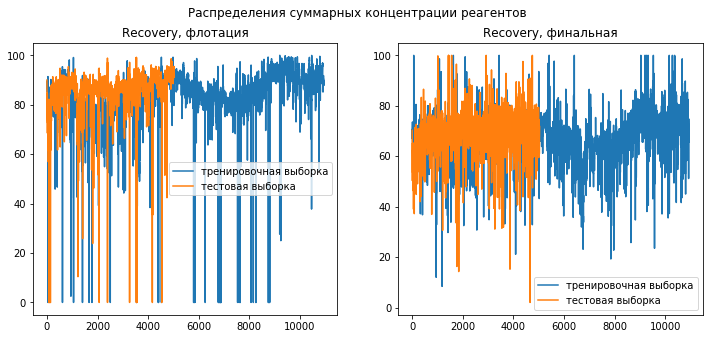

In [62]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))
plt.suptitle('Распределения суммарных концентрации реагентов');
    
axes[0].plot(target_train['rougher']);
axes[0].plot(target_test['rougher']);
axes[0].legend(['тренировочная выборка', 'тестовая выборка']);
axes[0].set_title('Recovery, флотация');

axes[1].plot(target_train['final']);
axes[1].plot(target_test['final']);
axes[1].legend(['тренировочная выборка', 'тестовая выборка']);
axes[1].set_title('Recovery, финальная');

Из графиков целевой характеристики видно, что на тестовой выборке, разброс значений меньше, чем на тренировочной. Это может привести к падению метрик на тестовой выборке. Кроме того при кросс-валидации необходимо разбивать выборку на много частей, поскольку одна отдельная выборка может быть искажены сильно выпадающими значениями.

Оценим коэффициент вариации для выборок.

In [63]:
#расчет коэффициентов вариации
#флотация
variation_rougher_train = variation(target_train['rougher'])
variation_rougher_test = variation(target_test['rougher'])

print('Recovery на этапе флотации')
print('Коэффициент вариации, тренировочная выборка', variation_rougher_train)
print('Коэффициент вариацииб тестовая выборка', variation_rougher_test)

Recovery на этапе флотации
Коэффициент вариации, тренировочная выборка 0.16380248932437483
Коэффициент вариацииб тестовая выборка 0.15118621718342906


In [64]:
#финальная стадия
variation_final_train = variation(target_train['final'])
variation_final_test = variation(target_test['final'])

print('Финальная Recovery')
print('Коэффициент вариации, тренировочная выборка', variation_final_train)
print('Коэффициент вариации, тестовая выборка', variation_final_test)

Финальная Recovery
Коэффициент вариации, тренировочная выборка 0.12101143638947649
Коэффициент вариации, тестовая выборка 0.10046893840084285


Расчеты показывают, что значения целевых признаков для тестовой выборке лежат в более узком диапазоне значений, чем для тренировочной выборки. 

### Обучение моделей, анализ их качества, выбор лучшей

Для предсказания эффективности очистки протестируем три модели регрессии: решающее дерево, случайный лес, линейная регрессия. Перед обучением моделей изучим возможную мультиколлинераность. 

*3.2.1.  Анализ мультиколлинераности*

In [65]:
#рассчитаем матрицу парных корреляций
matrix = features_train.corr('pearson').to_numpy()

In [66]:
#построение матрицы парных корреляций
def PlotCorrelationMatrix(matrix):
  
    #построение матрицы парных корреляций
    fig, axes = plt.subplots(1, 1, figsize=(12,8))
    plt.suptitle('Матрица парных корреляций');
    
    image = axes.imshow(pd.DataFrame(matrix), vmin = -0.6, vmax = 1, cmap="Accent")
    
    axes.set_xlabel('номер колонки')
    axes.set_ylabel('номер колонки')
    plt.colorbar(image)

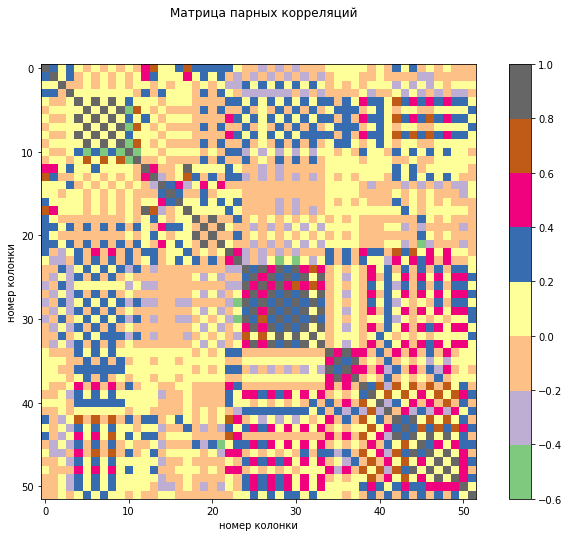

In [67]:
#визуализация матрицы парных корреляций
PlotCorrelationMatrix(matrix)

Визуальный анализ графического представления матрицы парных корреляций показывает, что существует довольно много колонок, значения в которых сильно коррелированны друг с другом. При этом степень корреляция высока - почти единица. Уберем из рассмотрения все колонки, коэффициент корреляции между которыми превышает критический. В качестве порога - возбьем величину равную 0.6.

In [68]:
#функция для выявления корреляций в строке для заданного ряда в корреляционной матрице
def CheckCorrelation(first, line_j, del_list, columns_list, correlation_matrix, threshold):
  
    last = correlation_matrix.shape[0]
    s = 0

    for i in range(first, last):  #проход вдоль ряда, для поиска значений превышающих пороговое
        
        if line_j != i:   #исключение корреляций колонок с сами собой
            if (abs(correlation_matrix[line_j][i]) >= threshold):  #корреляция превышает порог
                del_list.append(i)   
                s += 1
                
    return del_list                

In [69]:
#функция для анализа корреляций по всем данным матрицы корреляций
def CorrelatiedColumns(correlation_matrix, columns_list, threshold):
    
    del_list = []
    del_columns = []
    
    len_list = len(columns_list)
    i = 0
    
    while i < (len(columns_list) - 2):  #рекурсивное высывание функции поиска значений выше порога
        del_list = CheckCorrelation(i, i, del_list, columns_list, correlation_matrix, threshold)
        i += 1
    
    #сохранение названий колонок для дальнейшей работы
    del_list = pd.Series(del_list).value_counts().index.tolist()
    for i in range(len(del_list)):
        del_columns.append(columns_list[del_list[i]])
        
        
    return del_list, del_columns

In [70]:
#поиск колонок с сильной корреляцией значений
matrix = features_train.corr('pearson').to_numpy()

columns_corr, uncorrelated_names = CorrelatiedColumns(matrix, features_train.columns, 0.6)

#матрица некоррелированных колонок
uncorrelated_features = features_train.drop(uncorrelated_names, axis = 1).copy()
#features_train.shape

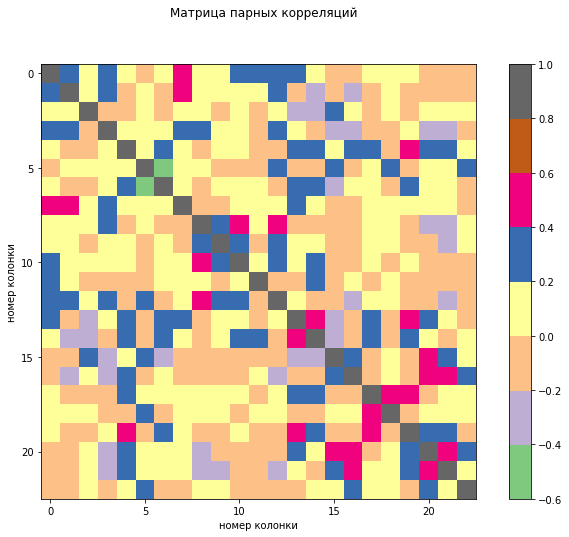

In [71]:
#расчет корреляционной матрицы и ее построение
matrix = uncorrelated_features.corr('pearson').to_numpy()
PlotCorrelationMatrix(matrix)

Как видно из рисунка избавление от сильнокоррелированых данных прошло успешно

In [72]:
#выделение не коррелированных данных
features_train_uncorrelated = features_train_scaled_df[uncorrelated_names]  
features_test_uncorrelated = features_test_scaled_df[uncorrelated_names]  

Напишем функцию для обучения моделей и расчета метрики на кросс-валидации. 

In [73]:
#функция обучения на кросс-валидации 
def CrossValidFit(model, features, target, n_splits, model_type):
      
    score_cv = []
    
    #разбиение тренировочной выборки
    kfold = KFold(n_splits, random_state = 12345)
    kfold.split(features)
    
    for train_index, test_index in kfold.split(features):
        features_train, features_test = features.iloc[train_index], features.iloc[test_index]
        target_train, target_test = target.iloc[train_index], target.iloc[test_index]
    
        #обучение модели
        model.fit(features_train, target_train)
        
        #расчет метрик
        score = sMAPE_score(model, features_test, target_test)
        
        #подсчет срендей метрики
        score_cv.append(score)
        
    mean_score = pd.Series(score_cv).mean()
    
    if model_type == 'LR':
        params = model.coef_
        
    if (model_type == 'TR') | (model_type == 'RF'):
        params = model.get_params(deep=True)
        
    if model_type == 'dummy': 
        params = None
    
    return mean_score, params

*3.2.2. Линейная регрессия*

Обучим модель и посчитаем метрики

In [74]:
#задание модели
model = LinearRegression()
    
#обучение модели
model.fit(features_train_uncorrelated, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
#расчет метрики sMAPE
score = sMAPE_score(model, features_train_uncorrelated, target_train)
print('Значение метрики для линейной регресии на тренировочной выборке:', score)

Значение метрики для линейной регресии на тренировочной выборке: 7.6804548485310145


Линейная регрессия дает прдесказания лучше, чем наивный регрессор. Проверим модель с помощью кросс-валидации.

In [76]:
#задание модели
model = LinearRegression()

In [77]:
#обучение на кросс-валидации
model = LinearRegression()

score = cross_val_score(model, features_train_uncorrelated, target_train, \
                               scoring = sMAPE_score, cv=20)

print('Средний sMAPE с кросс-валидацией', pd.Series(score).mean())

Средний sMAPE с кросс-валидацией 8.559462537566205


Как и ожидалось sMAPE на кросс-валидации лучше, чем наивный регрессор, но хуже, чем на все тренировочной выборке.

*3.2.3. Решающее дерево*

Сначала оценик метрики без подбора параметров.

In [78]:
#задание модели
model = DecisionTreeRegressor(max_depth = 10)
    
#обучение модели
model.fit(features_train_uncorrelated, target_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [79]:
#расчет метрики sMAPE
score = sMAPE_score(model, features_train_uncorrelated, target_train)
print('Значение метрики для решающего дерева на тренировочной выборке:', score)

Значение метрики для решающего дерева на тренировочной выборке: 5.3216832460664545


Значение метрики на всей выборке очень низкое, возможно модель переобучена. Оценим параметры на кросс-валидации.

In [80]:
#задание начальных параметров
features = features_train_uncorrelated
target = target_train

best_depth = None
best_split = None
best_leaf = None
best_score = 200
best_params = None

In [81]:
i = 0

#расчет accuracy в цикле для различных значений гиперпараметров
for depth in range(1,15,2):
    for split in range(2,23,2):
        for leaf in range(1,11,1):
            model = DecisionTreeRegressor(random_state = 12345, max_depth = depth, \
                                          min_samples_split = split, min_samples_leaf = leaf)
            #обучение модели
            score, params = CrossValidFit(model, features, target, 5, 'TR')

            if (i % 100) == 0:
                print('depth = ', depth)
            i += 1
            
            if score < best_score:
                best_score = score
                best_params = params
                best_depth = depth
                best_split = split
                best_leaf = leaf  

depth =  1
depth =  1
depth =  3
depth =  5
depth =  7
depth =  9
depth =  11
depth =  13


In [82]:
print('sMAPE на обучающей выборке', best_score)
print('max_depth = ', best_depth)
print('min_samples_split = ', best_split)
print('min_samples_leaf = ', best_leaf)

sMAPE на обучающей выборке 9.451680163828403
max_depth =  3
min_samples_split =  2
min_samples_leaf =  8


Значение на кросс-валидации хуже, чем на полной тренировочной выборке и хуже наивного классификатора. Это может быть связано с большой разнородностью данных и на большей выборке (тестовой) результат будет выше. 

In [83]:
model = DecisionTreeRegressor(random_state = 12345, max_depth = 3, \
                                min_samples_split = 2, min_samples_leaf = 8)

model.fit(features_train_uncorrelated, target_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [84]:
#расчет метрики sMAPE
score = sMAPE_score(model, features_test_uncorrelated, target_test)
print('Значение метрики для решающего дерева на тренировочной выборке:', score)

Значение метрики для решающего дерева на тренировочной выборке: 7.965007713966958


*3.2.4. Случайный лес*

Сначала оценик метрики без подбора параметров.

In [85]:
#задание модели
model = RandomForestRegressor(n_estimators = 10, max_depth = 3, \
                              min_samples_split = 2, min_samples_leaf = 8)
    
#обучение модели
model.fit(features_train_uncorrelated, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [86]:
#расчет метрики sMAPE
score = sMAPE_score(model, features_train_uncorrelated, target_train)
print('Значение метрики для случайного леса на тренировочной выборке:', score)

Значение метрики для случайного леса на тренировочной выборке: 8.049450427404654


Значение метрики на всей выборке лучше и линейной регресси и решающего дерева.

In [87]:
#задание начальных параметров
features = features_train_uncorrelated
target = target_train

best_depth = None
best_split = None
best_leaf = None
best_estimator = None
best_score = 200
best_params = None

In [88]:
i = 0

#расчет accuracy в цикле для различных значений гиперпараметров
for estimator in range(1,25,5):
    for depth in range(1,11,4):
        for split in range(5,21,5):
            for leaf in range(1,11,2):
                model = RandomForestRegressor(random_state = 12345, n_estimators = estimator, \
                                          max_depth = depth, min_samples_split = split, 
                                          min_samples_leaf = leaf)
                #обучение модели
                score, params = CrossValidFit(model, features, target, 3, 'TR')

                
                if (i % 100) == 0:
                    print('estimator = ', estimator, 'depth = ', depth)
                i += 1
            
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_estimator = estimator
                    best_depth = depth
                    best_split = split
                    best_leaf = leaf  

estimator =  1 depth =  1
estimator =  6 depth =  9
estimator =  16 depth =  5


In [89]:
print('sMAPE на обучающей выборке', best_score)
print('n_estimators = ', best_estimator)
print('max_depth = ', best_depth)
print('min_samples_split = ', best_split)
print('min_samples_leaf = ', best_leaf)

sMAPE на обучающей выборке 9.63264189541486
n_estimators =  6
max_depth =  5
min_samples_split =  5
min_samples_leaf =  1


### Проверка модели на тестовой выборке

Проверим модель на тестовой выборке. 

In [90]:
#подсчет sMAPE на тестовой выборке для линейной регрессии
model = LinearRegression()

model.fit(features_train_uncorrelated, target_train)

#расчет метрики sMAPE
score = sMAPE_score(model, features_test_uncorrelated, target_test)
print('Значение метрики для линейной регресии на тестовой выборке:', score)

Значение метрики для линейной регресии на тестовой выборке: 8.121384909549352


In [91]:
#подсчет sMAPE на тестовой выборке для решающего дерева
model = DecisionTreeRegressor(random_state = 12345, max_depth = 3, \
                              min_samples_split = 2, min_samples_leaf = 8)

model.fit(features_train_uncorrelated, target_train)

#расчет метрики sMAPE
score = sMAPE_score(model, features_test_uncorrelated, target_test)
print('Значение метрики для решающего дерева на тестовой выборке:', score)

Значение метрики для решающего дерева на тестовой выборке: 7.965007713966958


In [92]:
#подсчет sMAPE на тестовой выборке для случайного леса
model = RandomForestRegressor(random_state = 12345, n_estimators = 6, max_depth = 5, \
                              min_samples_split = 5, min_samples_leaf = 1)

model.fit(features_train_uncorrelated, target_train)

#расчет метрики sMAPE
score = sMAPE_score(model, features_test_uncorrelated, target_test)
print('Значение метрики для решающего дерева на тестовой выборке:', score)

Значение метрики для решающего дерева на тестовой выборке: 8.14744754756159


Для случайного леса значения на тестовой выборке также лучше, чем на кросс-валидации тренировочной. При этом наилучшие показатели метрики sMAPE получены для решающего дерева. 

### Выводы

- величина метрики sMAPE для наивного регрессора весьма низкое, что говорит о хорошем предсказании величины Recovery средним значением;
- коэффициент вариации для тестовой выборке ниже, чем для тренировочной, т.е. для тестовой выборки данные лежат ближе к среднему значению, чем для тренировочной выборки;
- лучшее значение метрики на тестовой выборке у модели - решающего дерева - 7.96%; 
- на кросс-валидации наилучшие значения метрики получается у линейной регрессии 8.55%;
- линейная регрессия наиболее оптимальная для предсказания, поскольку с одной стороны дает высокие значения метрики, а с другой может быть быстро обучена;
- слишком высокое значение метрики для решающего дерева и случайного леса на кросс-валидации возможно связана с неоптимальным подбором параметров и малым число разбиений, однако надо учитывать, что увеличение числа выборок или слишком частый шаг по значениям гиперпараметров приведет к очень длительному обучению модели;